Реализуем Stoc-AGDA и VR-AGDA [отсюда](https://arxiv.org/pdf/2002.09621.pdf) для задачи минимакса

![задача](1.png)
![бетта](2.png)
![1 алгоритм](3.png)
![2 алгоритм](4.png)

In [1]:
n = 1000
m = 500

In [2]:
import numpy as np

A = np.random.normal(loc=0, scale=1, size=m*n).reshape(m, n)
x_opt = np.random.normal(loc=0, scale=1, size=n)
eps =  np.random.normal(loc=0, scale=0.01, size=m)
M = np.eye(m)
y_0 = A @ x_opt + eps
lam = 3
beta = 3


In [3]:
def F(x, y):
    return (A @ x - y).T @ M @ (A @ x - y) - lam * ((y - y_0).T @ M @ (y - y_0))
def fx(x, y, j=-1):
    if j == -1:
        j = np.random.randint(0, y.size)
    return (x @ A[j,:] - y[j]) ** 2
def fy(x, y, j=''):
    if j == '':
        j = np.random.randint(0, y.size)
    return -2 * x @ A[j,:] * y[j] + (1 + lam) * y[j] ** 2 - 2 * lam * y[j] * y_0[j] + lam * y_0[j] ** 2



In [14]:
def Kernel_3(k):
    return 15 * k / 4 * (5 - 7 * k ** 2)
def sample_spherical(npoints=1, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec
tau = 0.0001
def gradx(x, y, func):
    e = sample_spherical(ndim=x.size).reshape(x.shape)
    return  x.size * (func(x + tau * e, y) - func(x - tau * e, y)) / (2*tau) * e
def gradx_Kernel(x, y, func):
    e = sample_spherical(ndim=x.size).reshape(x.shape)
    r = np.random.uniform(-1,1)
    return  x.size * (func(x + tau * r * e, y) - func(x - tau * r * e, y)) / (2*tau) *  Kernel_3(r) * e
def grad_fx(x, y, j = ''):
    if j == '':
        j = np.random.randint(0, y.size, 1)
    e = sample_spherical(ndim=x.size).reshape(x.shape)
    return x.size * (fx(x + tau * e, y, j) - fx(x - tau * e, y, j)) / (2*tau) * e
def grad_fx_Kernel(x, y, j = ''):
    if j == '':
        j = np.random.randint(0, y.size, 1)
    e = sample_spherical(ndim=x.size).reshape(x.shape)
    r = np.random.uniform(-1,1)
    return x.size * (fx(x + tau * r * e, y, j) - fx(x - tau * r * e, y, j)) / (2*tau) *  Kernel_3(r) * e

def grady(x, y, func):
    e = sample_spherical(ndim=y.size).reshape(y.shape)
    return  y.size * (func(x, y + tau * e) - func(x, y - tau * e)) / (2*tau) * e
def grady_Kernel(x, y, func):
    e = sample_spherical(ndim=y.size).reshape(y.shape)
    r = np.random.uniform(-1,1)
    return  y.size * (func(x, y + tau * r * e) - func(x, y - tau * r * e)) / (2*tau) *  Kernel_3(r) * e
def grad_fy(x, y, j = ''):
    if j == '':
        j = np.random.randint(0, y.size, 1)
    e = sample_spherical(ndim=y.size).reshape(y.shape)
    return y.size * (fy(x, y + tau * e, j) - fy(x, y - tau * e, j)) / (2*tau) * e
def grad_fy_Kernel(x, y, j = ''):
    if j == '':
        j = np.random.randint(0, y.size, 1)
    e = sample_spherical(ndim=y.size).reshape(y.shape)
    r = np.random.uniform(-1,1)
    return y.size * (fy(x, y + tau * r * e, j) - fy(x, y - tau * r * e, j)) / (2*tau) *  Kernel_3(r) * e

In [20]:
def Stoc_AGDA(func, gradx, grady, x0, y0,  tx=0.0001, ty=0.0001, n=10):
    array_of_error = []
    for _ in range(n):
        x0 -= tx * gradx(x0, y0, func)
        y0 += ty * grady(x0, y0, func)
        array_of_error.append(np.linalg.norm(x0 - x_opt)) #+ np.linalg.norm(grady(x0, y0, func))
        # print (array_of_error[-1])
    return x0, y0, array_of_error
    

def VR_AGDA(func, gradx, grady, grad_fx, grad_fy, x0, y0, tx=0.0001, ty=0.0001, n=10, N=10, T=3):
    array_of_error = []
    for _ in range(n):
        x = []
        y = []
        for t in range(T):
            x.append([x0])
            y.append([y0])
            for j in range(N):
                i1 = np.random.randint(0, y0.size)
                i2 = np.random.randint(0, y0.size)
                x[t].append( x[t][j] - tx * (grad_fx(x[t][j], y[t][j], i1) - grad_fx(x[t][0], y[t][0], i1) + gradx(x[t][0], y[t][0], func)) )
                y[t].append( y[t][j] + ty * (grad_fy(x[t][j], y[t][j], i2) - grad_fy(x[t][0], y[t][0], i2) + grady(x[t][0], y[t][0], func)) )
            x0 = x[t][N]
            y0 = y[t][N]
        t1 = np.random.randint(0, T)
        n1 = np.random.randint(0, N)
        x0 = x[t1][n1]
        y0 = y[t1][n1]
        array_of_error.append(np.linalg.norm(x0 - x_opt)) #+ np.linalg.norm(grady(x0, y0, func))
    return x0, y0, array_of_error

In [21]:
x, y, resi = Stoc_AGDA(F,gradx, grady, np.ones(n), np.ones(m))
x2, y2, resi2 = Stoc_AGDA(F, gradx_Kernel,  grady_Kernel, np.zeros(n), np.zeros(m))
x3, y3, resi3 = VR_AGDA(F, gradx,  grady, grad_fx, grad_fy, np.zeros(n), np.zeros(m))
x4, y4, resi4 = VR_AGDA(F, gradx_Kernel,  grady_Kernel, grad_fx_Kernel, grad_fy_Kernel, np.zeros(n), np.zeros(m))

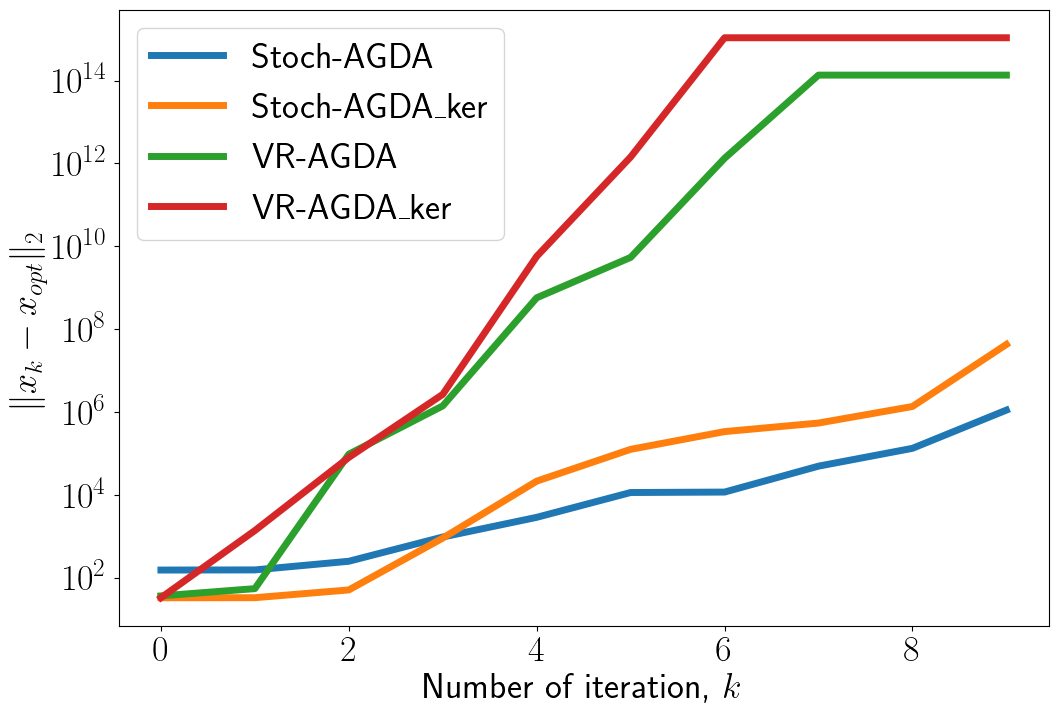

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

USE_COLAB = False
if not USE_COLAB:
    plt.rc("text", usetex=True)

plt.figure(figsize=(12,8))
plt.semilogy(np.arange(len(resi)), resi, 
             label=r"Stoch-AGDA", linewidth=5)
plt.semilogy(np.arange(len(resi2)), resi2, 
             label=r"Stoch-AGDA_ker", linewidth=5)
plt.semilogy(np.arange(len(resi3)), resi3, 
             label=r"VR-AGDA", linewidth=5)
plt.semilogy(np.arange(len(resi4)), resi4, 
             label=r"VR-AGDA_ker", linewidth=5)
plt.legend(loc="best", fontsize=26)
plt.xlabel("Number of iteration, $k$", fontsize=26)
plt.ylabel(r"$\| x_k - x_{opt}\|_2$", fontsize=26)
plt.xticks(fontsize=26)
_ = plt.yticks(fontsize=26)

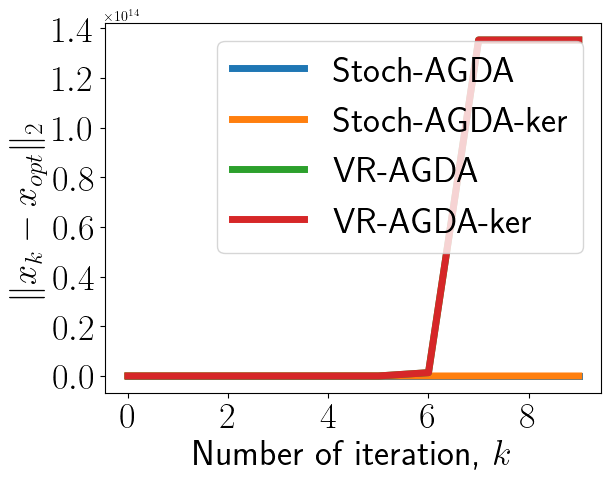

In [26]:
plt.plot(resi, label=r"Stoch-AGDA", linewidth=5)
plt.plot(resi2, label=r"Stoch-AGDA-ker", linewidth=5)
plt.plot(resi3, label=r"VR-AGDA", linewidth=5)
plt.plot(resi3, label=r"VR-AGDA-ker", linewidth=5)
plt.legend(loc="best", fontsize=26)
plt.xlabel("Number of iteration, $k$", fontsize=26)
plt.ylabel(r"$\| x_k - x_{opt}\|_2$", fontsize=26)
plt.xticks(fontsize=26)
_ = plt.yticks(fontsize=26)